In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
import random

Helper Functions

In [410]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [411]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0

    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [412]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [413]:
def missing(arr):
    return arr[0] == arr[1]

Data processing

In [414]:
## read and process data
df = pd.read_csv("data/filtered_ds.csv")
df = df.sort_values(by=["patient_id", "start_time_min"])
df = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_57900/831601334.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)


In [415]:
df

,id,patient_id,domain_ids,domain_scores,start_time_min,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
0,9316748,14696,"1,13","0.5850,0.7030",2017-12-06 14:20:08,0.585,0.0,0.00,0.000,0.000,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
1,9316749,14696,"4,5","0.6430,0.4500",2017-12-06 14:27:53,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.703,0.0
2,9316750,14696,9,0.9500,2017-12-06 14:38:16,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.000,0.0,0.000,0.703,0.0
3,9316751,14696,10,0.8070,2017-12-06 14:44:54,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.000,0.703,0.0
4,9316752,14696,"12,13","0.5070,0.7030",2017-12-06 14:50:15,0.585,0.0,0.00,0.643,0.450,0.0,0.0,0.0,0.95,0.807,0.0,0.507,0.703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194129,25142627,408963,5,0.6130,2020-06-26 06:55:04,0.000,0.0,0.63,0.800,0.613,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194130,25142628,408963,5,0.6260,2020-06-26 06:55:13,0.000,0.0,0.63,0.800,0.626,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194131,25142634,408963,5,0.6520,2020-06-26 07:01:30,0.000,0.0,0.63,0.800,0.652,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0
2194132,25157982,408963,5,0.6900,2020-07-03 23:15:37,0.000,0.0,0.63,0.800,0.690,0.0,0.0,0.0,0.00,0.000,0.0,0.000,0.454,0.0


In [416]:
## filter data to only sessions where the patient has all 14 domains (all ground truths)
model_data = df[["domain %d score" % i for i in range(1, 15)]]
model_data = filter_nonzero_rows(model_data, 0)
ground_truth = copy.deepcopy(model_data)

Training process

In [417]:
## define model
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 13
        hidden1 = 50
        hidden2 = 25
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden2, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [418]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 13 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
              
            # Calculating the loss function
            loss = loss_function(reconstructed, torch.tensor(y_train[i]).type(torch.float32))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.tensor(y_val[k]).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    return losses, val_losses, outputs, model

In [419]:
## take in two data arrays and return predictions for both in a tuple
def get_predictions(training, validation, model):
    model.eval()
    with torch.no_grad():
        return model(torch.tensor(training).type(torch.float32)), model(torch.tensor(validation).type(torch.float32))

In [420]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

In [421]:
## train mutliple run function
def multi_run(training_data, target_data, num_runs=3):
    losses_2d = []
    val_losses_2d = []

    for i in range(num_runs):
        model = AE()
        epochs = 10
        lr = 0.005

        # Validation using MSE Loss function
        loss_function = torch.nn.MSELoss()
        
        # Using an Adam Optimizer
        optimizer = torch.optim.Adam(model.parameters(),
                                    lr = lr)
        
        x_train, x_val, y_train, y_val = train_test_split(training_data, target_data, test_size=0.20)
        with torch.no_grad():
            initial_pred_train = model(torch.tensor(x_train).type(torch.float32))
            zero_loss = loss_function(torch.tensor(initial_pred_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))

            initial_pred_val = model(torch.tensor(x_val).type(torch.float32))
            zero_loss_val = loss_function(torch.tensor(initial_pred_val).type(torch.float32), torch.tensor(y_val).type(torch.float32))
        
        losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
        losses = [zero_loss.item()] + losses
        val_losses = [zero_loss_val.item()] + val_losses
        
        losses_2d.append(losses)
        val_losses_2d.append(val_losses)
    
    ## use the last trained model to get predictions
    predictions_train, predictions_val = get_predictions(x_train, x_val, model)

    return x_train, x_val, y_train, y_val, losses_2d, val_losses_2d, predictions_train, predictions_val

Individual domains

In [422]:
## run
def train_domain(target_domain : int, model_data=model_data, ground_truth=ground_truth):
    target_domain_name = "domain %d score" % target_domain
    target = copy.deepcopy(ground_truth[target_domain_name]).to_numpy().reshape(-1, 1)
    train_data = model_data.drop([target_domain_name], axis=1).to_numpy()
    # return results from training a model for multiple runs
    return multi_run(train_data, target)

Assign level groups

In [423]:
def find_level(points, point):
    for i in range(len(points) - 1, -1, -1):
        if point <= points[i]:
            return len(points) - i
    print("error")

In [424]:
## separate sessions into x number of levels based on the 13 domains
def level_assignment(data, num_levels=5):
    lvls = []
    # get an average
    avg = np.mean(data, axis=1)
    print(data.shape, avg.shape)
    # find level separation points
    high = avg.max()
    low = avg.min()
    seps = [high - (high - low) / num_levels * i for i in range(num_levels)]
    for p in avg:
        lvls.append(find_level(seps, p))
    return lvls

In [425]:
def results_domain(target_domain : int, model_data=model_data, ground_truth=ground_truth):
    # run training functions to get the results
    x_train, x_val, y_train, y_val, training_loss, validation_loss, predictions_train, predictions_val = train_domain(target_domain, model_data=model_data, ground_truth=ground_truth)
    # create numpy array with training data (not including target) but maintain train val split order
    original = np.hstack((np.vstack((x_train, x_val)), np.vstack((y_train, y_val))))
    # find level for each session (row)
    levels = np.vstack((np.array(level_assignment(x_train)).reshape(-1, 1), np.array(level_assignment(x_val)).reshape(-1, 1)))
    # work with predictions
    predictions = np.vstack((predictions_train.numpy(), predictions_val.numpy()))
    # hstack everything to create a big numpy array to convert into dataframe
    data_with_levels = np.hstack((original, levels))
    data_with_levels = np.hstack((data_with_levels, predictions))

    # create dataframe
    column_names = ["non-target domain score %d" % i for i in range(1, 14)] + ["target domain", "level", "predicted score"]
    df_with_levels = pd.DataFrame(data_with_levels, columns=column_names)
    return df_with_levels, training_loss, validation_loss

Visualization

In [519]:
domain_n = 14

In [520]:
results, traing_loss, val_loss = results_domain(domain_n, model_data=model_data, ground_truth=ground_truth)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_57900/1264182726.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_loss = loss_function(torch.tensor(initial_pred_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_57900/1264182726.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_loss_val = loss_function(torch.tensor(initial_pred_val).type(torch.float32), torch.tensor(y_val).type(torch.float32))
/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1,

(108904, 13) (108904,)
(27227, 13) (27227,)


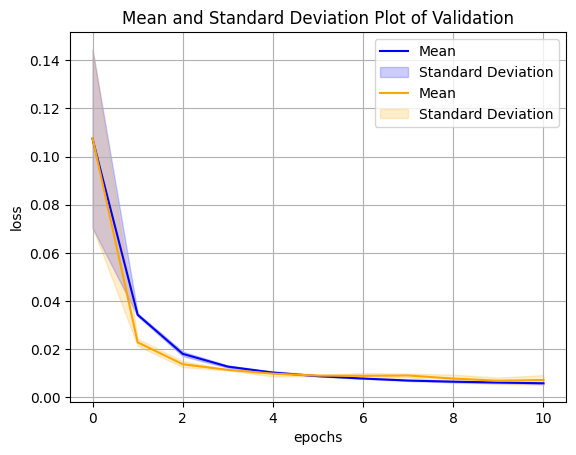

In [521]:
with torch.no_grad():
    plt.figure()
    plot_mean_and_std(traing_loss, "blue", "Training")
    plot_mean_and_std(val_loss, "orange", "Validation")

<Axes: title={'center': 'Predicting Domain 14'}, xlabel='predicted score', ylabel='Count'>

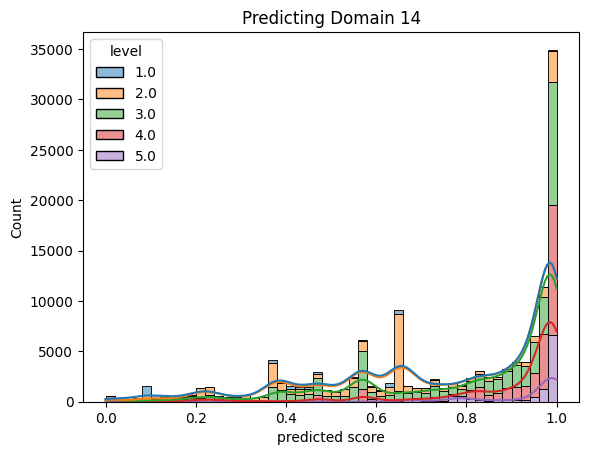

In [522]:
plt.figure()
plt.title("Predicting Domain %d" % domain_n)
sns.histplot(data=results, x="predicted score", bins=50, kde=True, hue="level", palette = "tab10", multiple="stack")

<Axes: title={'center': 'GT Domain 14'}, xlabel='target domain', ylabel='Count'>

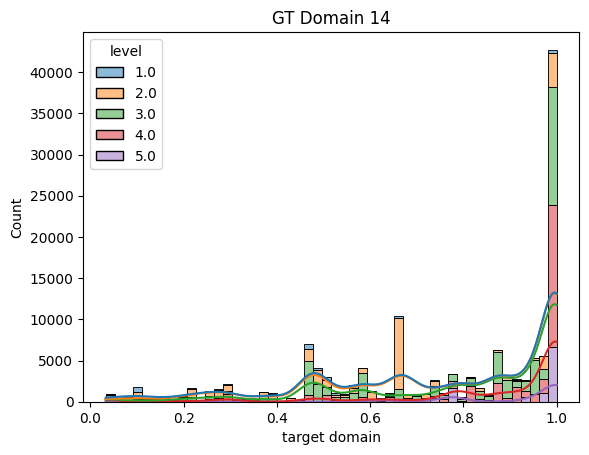

In [523]:
plt.figure()
plt.title("GT Domain %d" % domain_n)
sns.histplot(data=results, x="target domain", bins=50, kde=True, hue="level", palette = "tab10", multiple="stack")